### Plan
1. Get Image
2. Correct Distorsion
3. Grid
4. Detect

***

1. Get Image

In [53]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 

def get_image_from_camera(image_path: str):
    pass
    
# placeholder function
def get_image(image_path: str)-> np.ndarray:
    """
    Input: filepath of a PNG image
    Output: image as numpy array
    Example: get_image(os.path.join("..", "robot-env", "s1.png"))
    """
    try:
        img = cv2.imread(image_path) # BGR
        return img
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

img = get_image(os.path.join("..", "robot-env", "s1.png"))
print(img.shape, type(img[0][0][0]))

(1132, 1550, 3) <class 'numpy.uint8'>


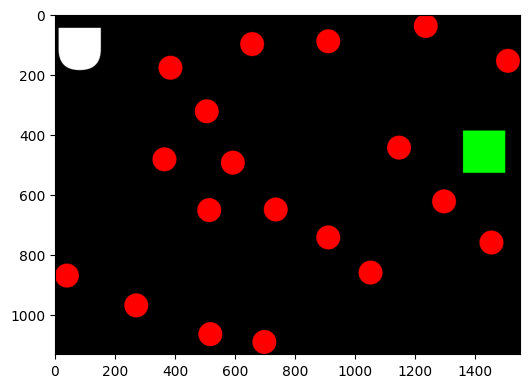

In [54]:
def show_cv2_img(img: np.ndarray, fig_size=(12,12)):
    plt.figure(figsize=fig_size)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # BGR -> RGB
    plt.show()

show_cv2_img(img, (6,6))

2. Correct distorsion

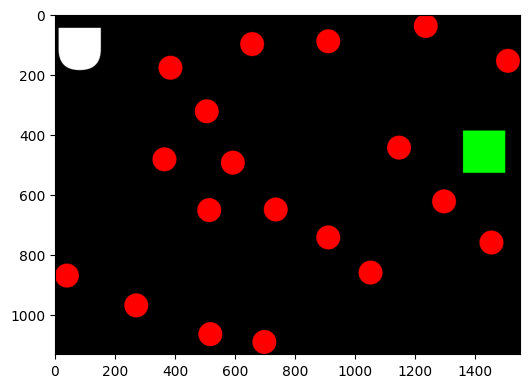

In [34]:
def correct_distorsion(img: np.ndarray) -> np.ndarray:
    # distorsion correction code
    return img

def crop_image(img: np.ndarray) -> np.ndarray:
    # extract the black arena from the scene
    pass

def threshold_image(img: np.ndarray) -> np.ndarray:
    # if (r,g,b) > (200,200,200) then white
    # if (r,g,b) > (150,0,0) then red
    # else black
    pass

img = correct_distorsion(img)
show_cv2_img(img, (6,6))

3. Grid

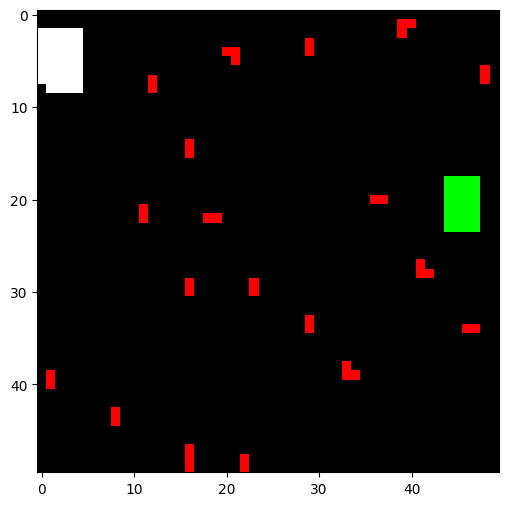

In [46]:
def get_dominant_color(block):
    """
    Determine the dominant color in the block based on priority:
    White > Red > Black. Returns the dominant color.
    """
    # Flatten the block to a list of pixels
    pixels = block.reshape(-1, 3)

    # Define color thresholds
    white_thresh = [200, 200, 200]   # Anything brighter is considered white
    red_thresh = [150, 0, 0]         # Pixels with high red channel and low green/blue are considered red
    black_thresh = [50, 50, 50]      # Anything darker is considered black

    has_white = np.any((pixels >= white_thresh).all(axis=1))
    has_red = np.any((pixels[:, 2] < 50) & (pixels[:, 1] < 50) & (pixels[:, 0] > red_thresh[0]))
    has_black = np.any((pixels <= black_thresh).all(axis=1))

    # Priority: White > Red > Black
    if has_white:
        return [255, 255, 255]  # White
    elif has_red:
        return [0, 0, 255]      # Red (OpenCV uses BGR format)
    elif has_black:
        return [0, 0, 0]        # Black
    else:
        # If no dominant color, return average color
        return block.mean(axis=(0, 1)).astype(int)


def discretize_image(img, grid_size):
    """
    Discretizes an OpenCV image using a grid of grid_size x grid_size cells.
    """
    height, width, _ = img.shape
    cell_height = height // grid_size
    cell_width = width // grid_size

    # Initialize the grid image and discretized image
    grid_image = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)
    discretized_image = np.copy(img)

    # Loop over each cell in the grid
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate the block boundaries
            start_y = i * cell_height
            end_y = (i + 1) * cell_height
            start_x = j * cell_width
            end_x = (j + 1) * cell_width

            # Extract the block from the original image
            block = img[start_y:end_y, start_x:end_x]

            # Get the dominant color for the block
            dominant_color = get_dominant_color(block)

            # Check for collision detection
            if np.any((block.reshape(-1, 3) >= [200, 200, 200]).all(axis=1)) and \
               np.any((block.reshape(-1, 3)[:, 2] < 50) & (block.reshape(-1, 3)[:, 1] < 50) & (block.reshape(-1, 3)[:, 0] > 150)):
                print("COLLISION DETECTED in block ({}, {})".format(i, j))

            # Assign the dominant color to the grid image
            grid_image[i, j] = dominant_color

            # Reassign all pixels in the discretized image block to the dominant color
            discretized_image[start_y:end_y, start_x:end_x] = dominant_color

    return grid_image, discretized_image


grid_size = 50
grid_image, discretized_img = discretize_image(img, grid_size)
show_cv2_img(grid_image, (6,6))

4. Detect